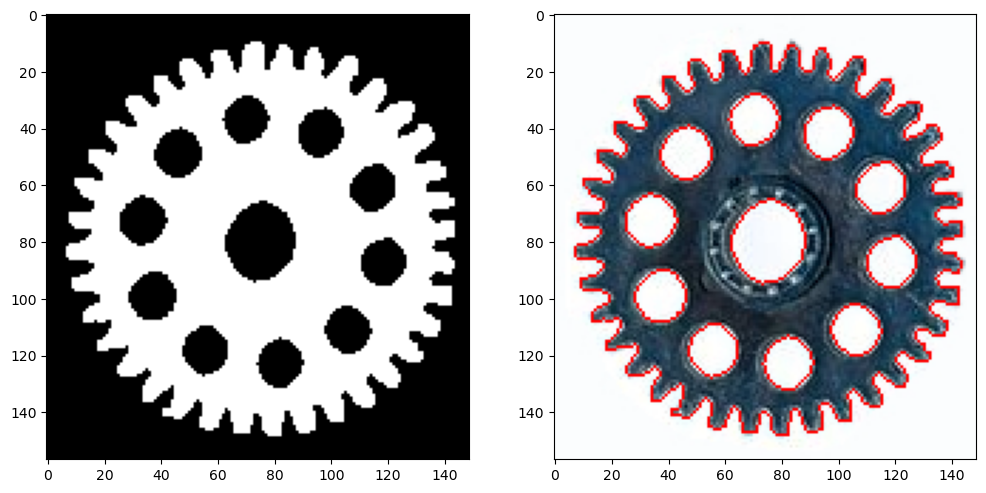

In [49]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = cv2.imread('trybik.jpg')
imgG = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgG, 127, 255, cv2.THRESH_BINARY)
thresh = cv2.erode(thresh, np.ones((3, 3)))
thresh = cv2.bitwise_not(thresh)


contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE,
                                        cv2.CHAIN_APPROX_NONE)

cv2.drawContours(img, contours, -1, (255, 0, 0))

f, ax =plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(thresh, 'gray')
ax[1].imshow(img)


In [60]:
import numpy as np

sobelx = cv2.Sobel(imgG, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(imgG, cv2.CV_64F, 0, 1, ksize=5)

A = np.sqrt(sobelx**2 + sobely**2)
A /= np.max(A)

alfa = np.arctan2(sobely, sobelx)
alfa = alfa * 180 / np.pi

m_dict = cv2.moments(thresh, 1)
m00 = m_dict['m00']
m01 = m_dict['m01']
m10 = m_dict['m10']
C = (m10/m00, m01/m00)

R_table = [[] for _ in range(360)]

for c in contours:
    for i in c:
        d = i[0]
        print(alfa[d[0], d[1]])

IndexError: index 1 is out of bounds for axis 0 with size 1